In [47]:
# imports libraries
import pickle						# import/export lists
import re 							# regular expression
import pandas as pd					# dataframes
import matplotlib.pyplot as plt		# plot graphics

In [44]:
# opens raw data
with open ('df_profile', 'rb') as fp:
    df_profile = pickle.load(fp)

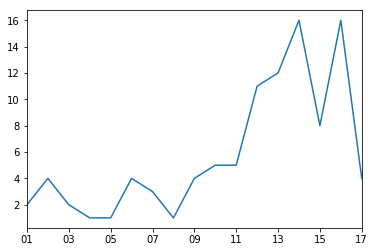

In [72]:
# calculates user entry rate
entry_year = df_profile['join_year'][[row != 'NaN' for row in df_profile['join_year']]]
entry = entry_year.value_counts().sort_index()
entry.plot()

plt.show()